# Generate some reference images & gradients.

In [2]:
#@title: Imports
# Train a whole image, see how that progresses for reference.
# Maybe capture first training step as something... ?
import math
import os
import time
from pathlib import Path
import mediapy

import numpy as np
import torch
from gsplat import project_gaussians
from gsplat import rasterize_gaussians
from gsplat import spherical_harmonics

import matplotlib.pyplot as plt

from PIL import Image

from safetensors import safe_open
from safetensors.torch import save_file

In [3]:
def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms
    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor.to("cuda:0")

In [4]:
# Helper functions
def fov_to_focal(fov: float, img_size: int) -> float: 
    return 0.5 * float(img_size) / math.tan(0.5 * fov)

In [5]:
crab_img = image_path_to_tensor("./crab.png")
device = torch.device("cuda:0")

def execute_test(means, log_scales, quats, coeffs, opacities, viewmat, name: str):
    background = torch.zeros(3, device=device)

    means.requires_grad = True
    log_scales.requires_grad = True
    quats.requires_grad = True
    coeffs.requires_grad = True
    opacities.requires_grad = True
    viewmat.requires_grad = False

    fov_x = math.pi / 2.0
    H, W, _ = crab_img.shape
    focal = fov_to_focal(fov_x, W)

    B_SIZE = 16

    (
        xys,
        depths,
        radii,
        conics,
        _compensation,
        num_tiles_hit,
        _cov3d,
    ) = project_gaussians(
        means,
        log_scales.exp(),
        1,
        quats,
        viewmat,
        focal,
        focal,
        W / 2,
        H / 2,
        H,
        W,
        B_SIZE,
        0.01
    )

    viewdirs = means - viewmat[:3, 3]  # (N, 3)
    colors = spherical_harmonics(0, viewdirs, coeffs) + 0.5

    out_img = rasterize_gaussians(
        xys,
        depths,
        radii,
        conics,
        num_tiles_hit,
        colors,
        torch.sigmoid(opacities[:, None]),
        H,
        W,
        B_SIZE,
        background,
    )[..., :3]
    out_img.retain_grad()
    conics.retain_grad()
    xys.retain_grad()
    mediapy.show_image((out_img.detach().cpu().numpy() * 255.0).astype(np.uint8), width=W*4, height=H*4)

    loss = ((out_img - crab_img) ** 2).mean()
    loss.backward()
    tensors = {
        "means": means,
        "scales": log_scales,
        "coeffs": coeffs,
        "quats": quats,
        "opacities": opacities,
        "depths": depths,
        "xys": xys,
        "radii": radii,
        "conics": conics,
        "out_img": out_img,

        "v_xy": xys.grad,
        "v_conics": conics.grad,


        "v_means": means.grad,
        "v_scales": log_scales.grad,
        "v_coeffs": coeffs.grad,
        "v_quats": quats.grad,
        "v_opacities": opacities.grad,
        "v_out_img": out_img.grad,
    }
    save_file(tensors, f"./{name}.safetensors")

c:\Users\A-Bru\anaconda3\envs\nerfstudio\lib\site-packages\torch\utils\cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


""

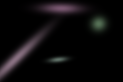

In [6]:

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(14)
    num_points = 4
    means = 10.5 * (torch.rand(num_points, 3, device=device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=device) * 2.5).log()
    coeffs = torch.rand(num_points, 1, 3, device=device)
    u = torch.rand(num_points, 1, device=device)
    v = torch.rand(num_points, 1, device=device)
    w = torch.rand(num_points, 1, device=device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=device) * 0.5 + 0.5

    # TODO: Our coords are flipped or?
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=device,
    )
    execute_test(means, log_scales, quats, coeffs, opacities, viewmat, "tiny_case")

test_case()

""

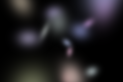

In [7]:

# Simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(3)
    num_points = 16
    means = 10.0 * (torch.rand(num_points, 3, device=device) - 0.5)
    log_scales = torch.rand(num_points, 3, device=device).log() * 0.5
    coeffs = torch.rand(num_points, 1, 3, device=device)
    u = torch.rand(num_points, 1, device=device)
    v = torch.rand(num_points, 1, device=device)
    w = torch.rand(num_points, 1, device=device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=device) * 0.5 + 0.5

    # TODO: Our coords are flipped or?
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=device,
    )
    execute_test(means, log_scales, quats, coeffs, opacities, viewmat, "basic_case")

test_case()


""

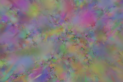

In [8]:

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(4)
    device = torch.device("cuda:0")
    num_points = 76873

    means = 2000.0 * (torch.rand(num_points, 3, device=device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=device) * 15.0 + 0.05).log()
    coeffs = torch.rand(num_points, 1, 3, device=device) * 2.0 - 1.0
    u = torch.rand(num_points, 1, device=device)
    v = torch.rand(num_points, 1, device=device)
    w = torch.rand(num_points, 1, device=device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=device)
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=device,
    )
    execute_test(means, log_scales, quats, coeffs, opacities, viewmat, "mix_case")

test_case()

In [18]:
# Very basic benchmark of some stuff.
def benchmark(iter, num_points):
    torch.manual_seed(4)

    # Generate input data.
    means = 1000.0 * (torch.rand(num_points, 3, device=device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=device) * 15.0 + 0.05).log()
    coeffs = torch.rand(num_points, 1, 3, device=device) * 2.0 - 1.0
    
    u = torch.rand(num_points, 1, device=device)
    v = torch.rand(num_points, 1, device=device)
    w = torch.rand(num_points, 1, device=device)
    
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    
    opacities = torch.rand(num_points, device=device)
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=device,
    )

    crab_img = image_path_to_tensor("./crab.png")
    crab_img = crab_img.to(device)
    background = torch.zeros(3, device=device)

    means.requires_grad = True
    log_scales.requires_grad = True
    quats.requires_grad = True
    coeffs.requires_grad = True
    opacities.requires_grad = True
    viewmat.requires_grad = False

    fov_x = math.pi / 2.0
    H, W, _ = crab_img.shape
    focal = fov_to_focal(fov_x, W)

    B_SIZE = 16

    tensors = {
        "means": means,
        "scales": log_scales,
        "coeffs": coeffs,
        "quats": quats,
        "opacities": opacities,
    }
    save_file(tensors, f"./bench_{iter}.safetensors")

    start_time = time.time()
    for _ in range(32):
        (
            xys,
            depths,
            radii,
            conics,
            _compensation,
            num_tiles_hit,
            _cov3d,
        ) = project_gaussians(
            means,
            log_scales.exp(),
            1,
            quats,
            viewmat,
            focal,
            focal,
            W / 2,
            H / 2,
            H,
            W,
            B_SIZE,
            0.01
        )

        viewdirs = means - viewmat[:3, 3]  # (N, 3)
        colors = spherical_harmonics(0, viewdirs, coeffs) + 0.5
        out_img = rasterize_gaussians(
            xys,
            depths,
            radii,
            conics,
            num_tiles_hit,
            colors,
            torch.sigmoid(opacities[:, None]),
            H,
            W,
            B_SIZE,
            background,
        )[..., :3]
        out_img.retain_grad()
        xys.retain_grad()
        loss = ((out_img - crab_img) ** 2).mean()
        loss.backward()

    torch.cuda.synchronize(device)
    end_time = time.time()
    return end_time - start_time

splat_counts = [int(2 ** n) for n in range(10, 20)]
times = np.array([[benchmark(i, count) for i, count in enumerate(splat_counts)] for _ in range(5)])
times = np.mean(times, axis=0)


In [19]:
times

array([0.0698885 , 0.07101674, 0.07038813, 0.08024106, 0.08029532,
       0.07582688, 0.07729602, 0.08812799, 0.11145873, 0.16941166])

In [23]:
rust_times = [
    19.51 / 1000.0,
    19.18 / 1000.0,
    19.25 / 1000.0,
    19.54 / 1000.0,
    23.82 / 1000.0,
    35.89 / 1000.0,
    56.85 / 1000.0,
    92.56 / 1000.0,
    173.7 / 1000.0,
    356.8 / 1000.0,
]

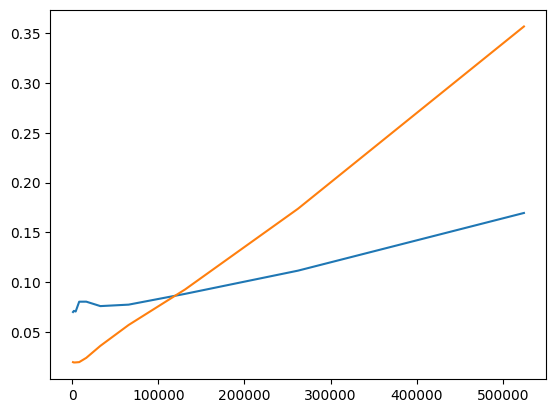

In [24]:
plt.plot(splat_counts, times)
plt.plot(splat_counts, rust_times)